## Constructing a riskless AMERIBOR yield curve for USD
The first thing we need to do to price any option on a US equity is construct the so-called riskless yield curve for USD. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I this notebook I use [Ameribor](https://www.investopedia.com/ameribor-6260927) rates as proxies for riskless rates. They are expressed in Actual/360 day count convention.

I use the following dataseries from FRED to accomplish the task: [AMERIBOR Term Structure](https://fred.stlouisfed.org/release/tables?rid=504&eid=1227517).

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas datareader
#!pip install pandas-datareader -U

In [2]:
import locale
from datetime import date, datetime

from dateutil.relativedelta import relativedelta
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import numpy as np
import pandas as pd

from volatility import parameter_estimators
from volatility import volatility_trackers
from pricing import curves, options

_ = locale.setlocale(locale.LC_ALL, '')

In [3]:
today = date.today()

# Offsetting to the next business day if today is not a business day, not doing it would artificially raise
# the price of options priced.
today = BDay(1).rollforward(today)

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['AMERIBOR', 'AMBOR1W', 'AMBOR1M', 'AMBOR3M', 'AMBOR6M', 'AMBOR1Y', 'AMBOR2Y'],
    today - BDay(3), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

offsets = [relativedelta(), relativedelta(weeks=+1), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2)]


# Some adjustments are required to bring AMERIBOR rates to an actual/actual day count convention
data *= 365 / 360 # to x/actual

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=1)

### Optional: Visualizing the riskless AMERIBOR yield curve for USD

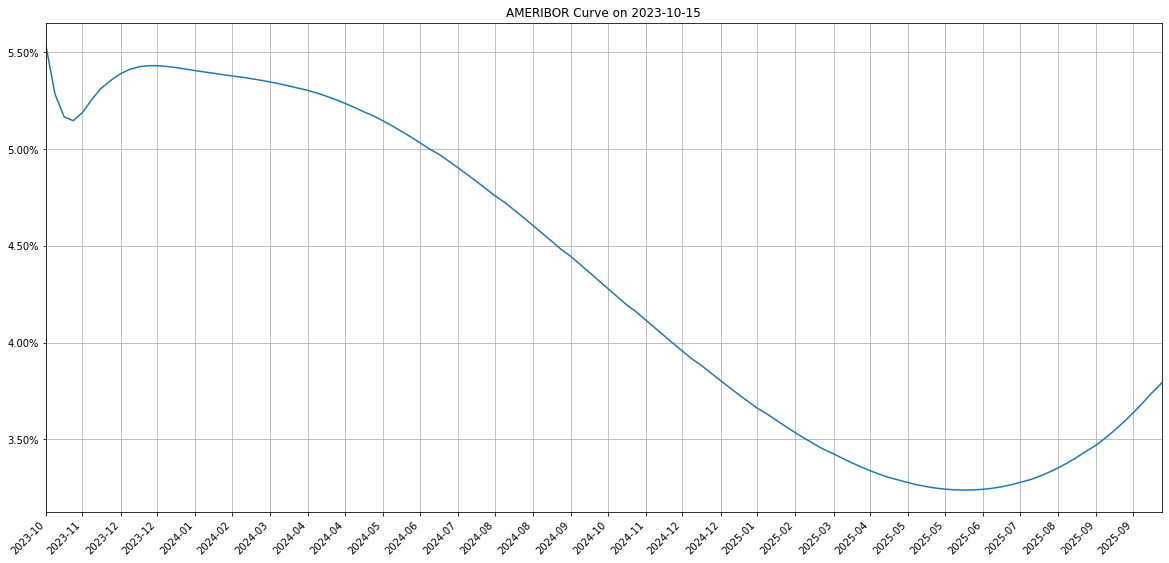

In [4]:
import matplotlib.ticker as mtick
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='AMERIBOR Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

In [10]:
assert curve.date == today.date()